In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-proccessed-data/Processed Data.csv


# GRU GLOVE

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
batch_size = 32
epochs = 15
dropout = 0.2
learning_rate = 0.0001
hidden_size = 128
num_layers = 3  # GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset (adjust to your dataset)
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation (optional, based on your data split)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Using device: cuda
GloVe embeddings loaded.
Epoch 1/15, Loss: 0.5890
Epoch 2/15, Loss: 0.2973
Epoch 3/15, Loss: 0.1796
Epoch 4/15, Loss: 0.1281
Epoch 5/15, Loss: 0.1021
Epoch 6/15, Loss: 0.0871
Epoch 7/15, Loss: 0.0798
Epoch 8/15, Loss: 0.0743
Epoch 9/15, Loss: 0.0691
Epoch 10/15, Loss: 0.0664
Epoch 11/15, Loss: 0.0611
Epoch 12/15, Loss: 0.0591
Epoch 13/15, Loss: 0.0556
Epoch 14/15, Loss: 0.0541
Epoch 15/15, Loss: 0.0523
Accuracy: 0.9802
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4655
           1       0.97      0.99      0.98      4721

    accuracy                           0.98      9376
   macro avg       0.98      0.98      0.98      9376
weighted avg       0.98      0.98      0.98      9376



Accuracy: 0.9802
                precision    recall  f1-score   support

    Depressive       0.99      0.97      0.98      4655
Non-depressive       0.97      0.99      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



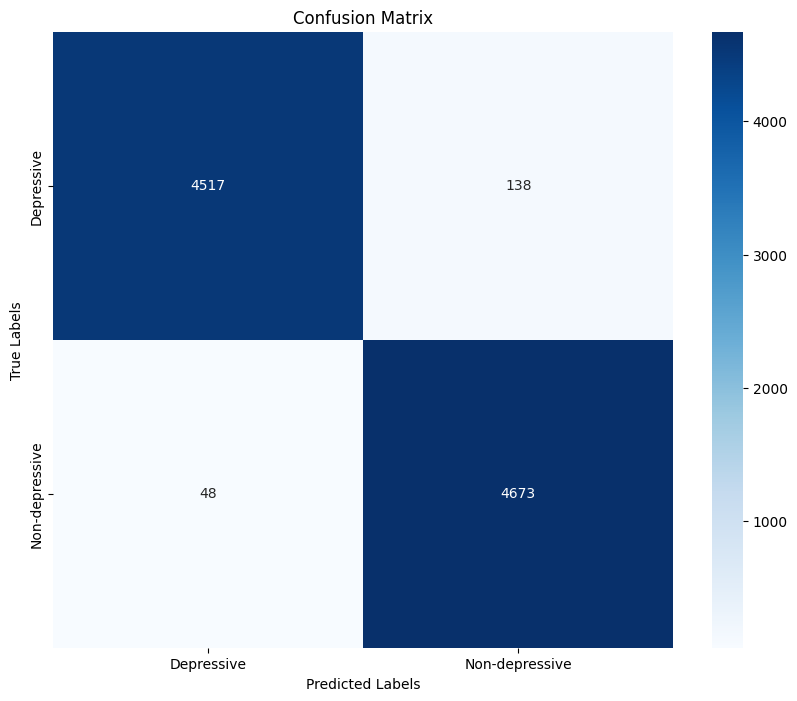

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru4.jpg


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru4.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
GloVe embeddings loaded.
Epoch 1/10, Loss: 0.4494
Epoch 2/10, Loss: 0.1979
Epoch 3/10, Loss: 0.1172
Epoch 4/10, Loss: 0.0809
Epoch 5/10, Loss: 0.0638
Epoch 6/10, Loss: 0.0632
Epoch 7/10, Loss: 0.0498
Epoch 8/10, Loss: 0.0496
Epoch 9/10, Loss: 0.0490
Epoch 10/10, Loss: 0.0499
Accuracy: 0.9789
                precision    recall  f1-score   support

    Depressive       0.99      0.97      0.98      4655
Non-depressive       0.97      0.99      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



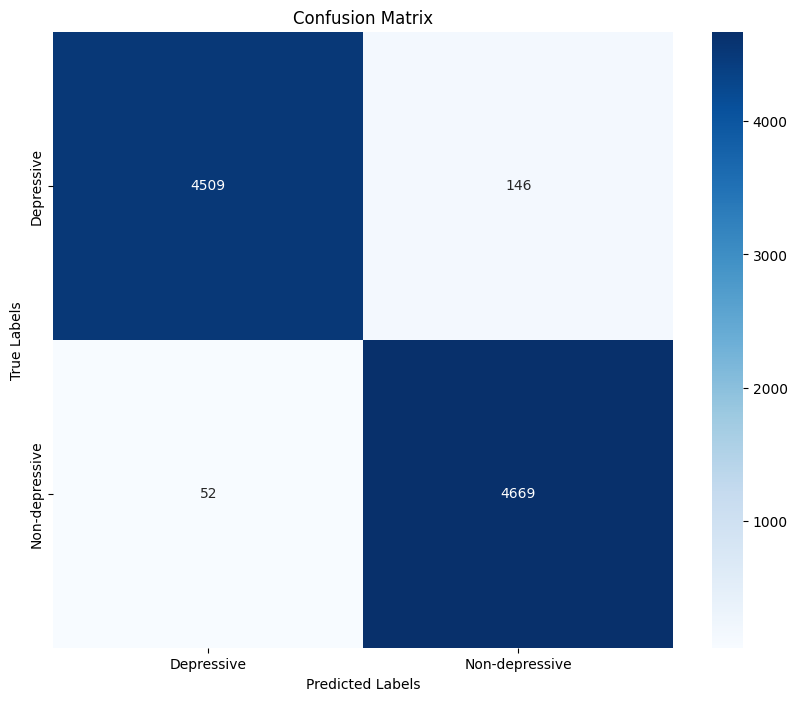

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_2.jpg


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 16
epochs = 10
dropout = 0.1
learning_rate = 0.001
hidden_size = 128
num_layers = 2  # GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_2.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
GloVe embeddings loaded.
Epoch 1/20, Loss: 0.4463
Epoch 2/20, Loss: 0.2017
Epoch 3/20, Loss: 0.1249
Epoch 4/20, Loss: 0.0888
Epoch 5/20, Loss: 0.0684
Epoch 6/20, Loss: 0.0631
Epoch 7/20, Loss: 0.0551
Epoch 8/20, Loss: 0.0515
Epoch 9/20, Loss: 0.0531
Epoch 10/20, Loss: 0.0493
Epoch 11/20, Loss: 0.0551
Epoch 12/20, Loss: 0.0471
Epoch 13/20, Loss: 0.0491
Epoch 14/20, Loss: 0.0471
Epoch 15/20, Loss: 0.0458
Epoch 16/20, Loss: 0.0443
Epoch 17/20, Loss: 0.0470
Epoch 18/20, Loss: 0.0483
Epoch 19/20, Loss: 0.0443
Epoch 20/20, Loss: 0.0444
Accuracy: 0.9774
                precision    recall  f1-score   support

    Depressive       0.97      0.98      0.98      4655
Non-depressive       0.98      0.97      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



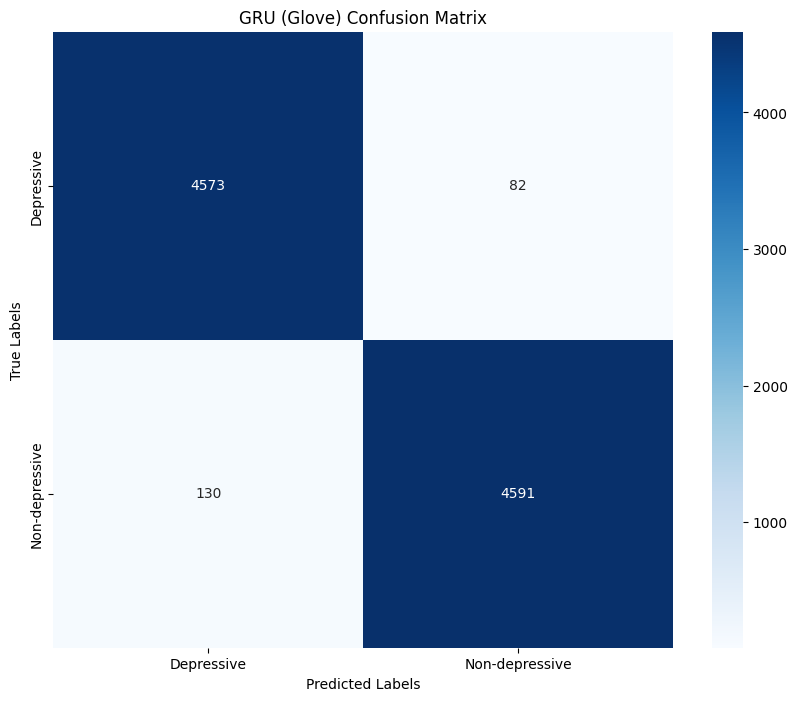

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_3.jpg


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 16
epochs = 20
dropout = 0.001
learning_rate = 0.001
hidden_size = 128
num_layers = 3  # GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Glove)Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_3.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
GloVe embeddings loaded.
Epoch 1/25, Loss: 0.4662
Epoch 2/25, Loss: 0.2200
Epoch 3/25, Loss: 0.1428
Epoch 4/25, Loss: 0.1093
Epoch 5/25, Loss: 0.0880
Epoch 6/25, Loss: 0.0720
Epoch 7/25, Loss: 0.0610
Epoch 8/25, Loss: 0.0541
Epoch 9/25, Loss: 0.0567
Epoch 10/25, Loss: 0.0603
Epoch 11/25, Loss: 0.0525
Epoch 12/25, Loss: 0.0511
Epoch 13/25, Loss: 0.0528
Epoch 14/25, Loss: 0.0532
Epoch 15/25, Loss: 0.0492
Epoch 16/25, Loss: 0.0456
Epoch 17/25, Loss: 0.0475
Epoch 18/25, Loss: 0.0486
Epoch 19/25, Loss: 0.0433
Epoch 20/25, Loss: 0.0430
Epoch 21/25, Loss: 0.0465
Epoch 22/25, Loss: 0.0430
Epoch 23/25, Loss: 0.0466
Epoch 24/25, Loss: 0.0489
Epoch 25/25, Loss: 0.0451
Accuracy: 0.9761
                precision    recall  f1-score   support

    Depressive       0.97      0.98      0.98      4655
Non-depressive       0.98      0.97      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg  

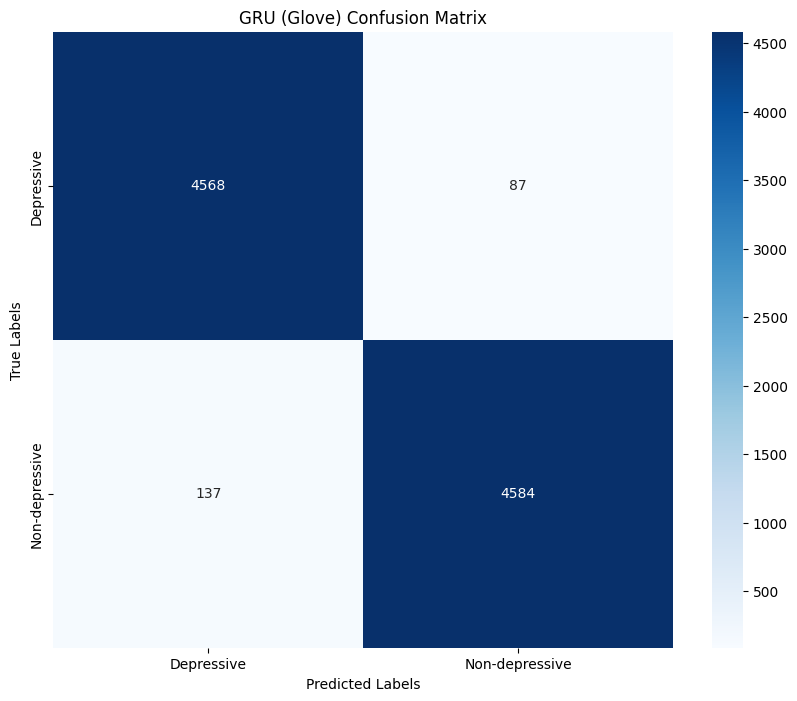

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_4.jpg


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 32
epochs = 25
dropout = 0.3
learning_rate = 0.001
hidden_size = 128
num_layers = 4  # GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Glove) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_4.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


# GRU (Word2Vec)

Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/10, Loss: 0.4526
Epoch 2/10, Loss: 0.2079
Epoch 3/10, Loss: 0.1175
Epoch 4/10, Loss: 0.0788
Epoch 5/10, Loss: 0.0647
Epoch 6/10, Loss: 0.0581
Epoch 7/10, Loss: 0.0573
Epoch 8/10, Loss: 0.0532
Epoch 9/10, Loss: 0.0490
Epoch 10/10, Loss: 0.0475
Accuracy: 0.9731
                precision    recall  f1-score   support

    Depressive       0.96      0.99      0.97      4655
Non-depressive       0.99      0.96      0.97      4721

      accuracy                           0.97      9376
     macro avg       0.97      0.97      0.97      9376
  weighted avg       0.97      0.97      0.97      9376



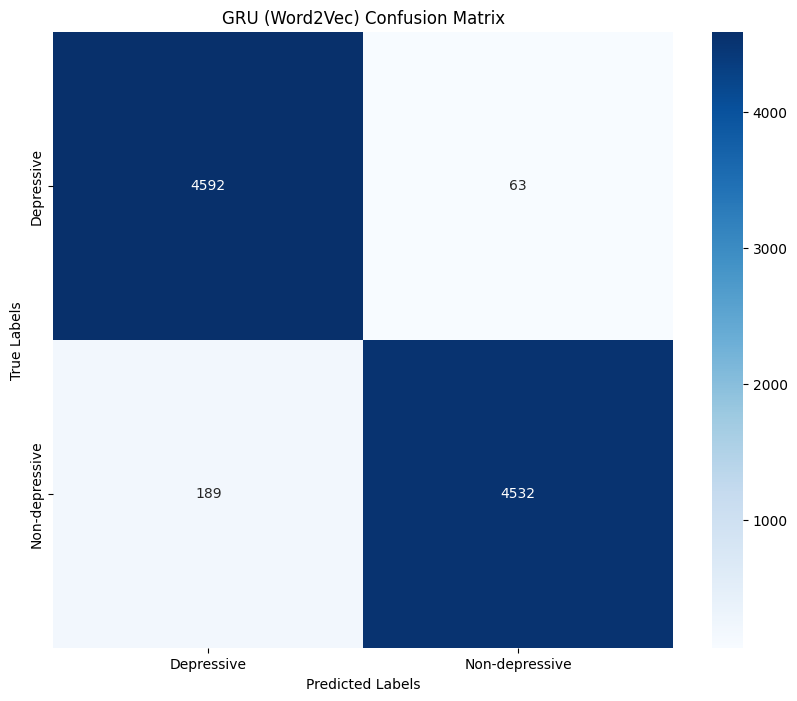

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_word2vec1.jpg


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 16
epochs = 10
dropout = 0.2
learning_rate = 0.001
hidden_size = 128
num_layers = 3  # GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_word2vec1.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/20, Loss: 0.4742
Epoch 2/20, Loss: 0.2134
Epoch 3/20, Loss: 0.1245
Epoch 4/20, Loss: 0.0810
Epoch 5/20, Loss: 0.0628
Epoch 6/20, Loss: 0.0521
Epoch 7/20, Loss: 0.0514
Epoch 8/20, Loss: 0.0466
Epoch 9/20, Loss: 0.0476
Epoch 10/20, Loss: 0.0461
Epoch 11/20, Loss: 0.0476
Epoch 12/20, Loss: 0.0441
Epoch 13/20, Loss: 0.0465
Epoch 14/20, Loss: 0.0514
Epoch 15/20, Loss: 0.0449
Epoch 16/20, Loss: 0.0441
Epoch 17/20, Loss: 0.0428
Epoch 18/20, Loss: 0.0420
Epoch 19/20, Loss: 0.0415
Epoch 20/20, Loss: 0.0434
Accuracy: 0.9801
                precision    recall  f1-score   support

    Depressive       0.98      0.98      0.98      4655
Non-depressive       0.98      0.98      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



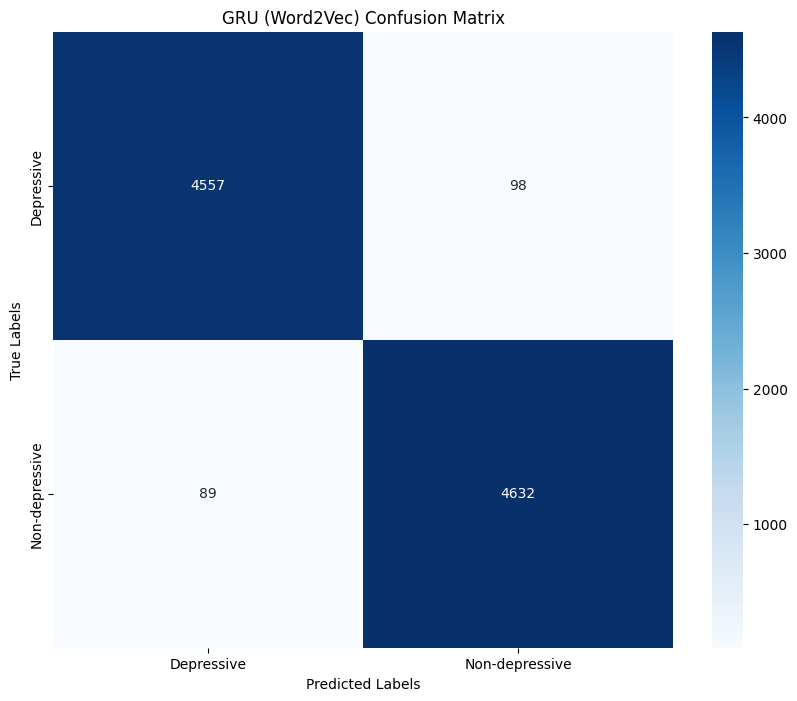

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_word2vec1.jpg


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 32
epochs = 20
dropout = 0.4
learning_rate = 0.001
hidden_size = 128
num_layers = 2  # GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_word2vec2.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/25, Loss: 0.6678
Epoch 2/25, Loss: 0.4406
Epoch 3/25, Loss: 0.2982
Epoch 4/25, Loss: 0.2407
Epoch 5/25, Loss: 0.2071
Epoch 6/25, Loss: 0.1814
Epoch 7/25, Loss: 0.2167
Epoch 8/25, Loss: 0.2208
Epoch 9/25, Loss: 0.2332
Epoch 10/25, Loss: 0.2734
Epoch 11/25, Loss: 0.2656
Epoch 12/25, Loss: 0.2571
Epoch 13/25, Loss: 0.2725
Epoch 14/25, Loss: 0.2683
Epoch 15/25, Loss: 0.2825
Epoch 16/25, Loss: 0.2800
Epoch 17/25, Loss: 0.2692
Epoch 18/25, Loss: 0.2957
Epoch 19/25, Loss: 0.2935
Epoch 20/25, Loss: 0.2769
Epoch 21/25, Loss: 0.2901
Epoch 22/25, Loss: 0.3216
Epoch 23/25, Loss: 0.3329
Epoch 24/25, Loss: 0.3414
Epoch 25/25, Loss: 0.3365
Accuracy: 0.8956
                precision    recall  f1-score   support

    Depressive       0.90      0.89      0.89      4655
Non-depressive       0.89      0.90      0.90      4721

      accuracy                           0.90      9376
     macro avg       0.90      0.90      0.90      9376
  weighted av

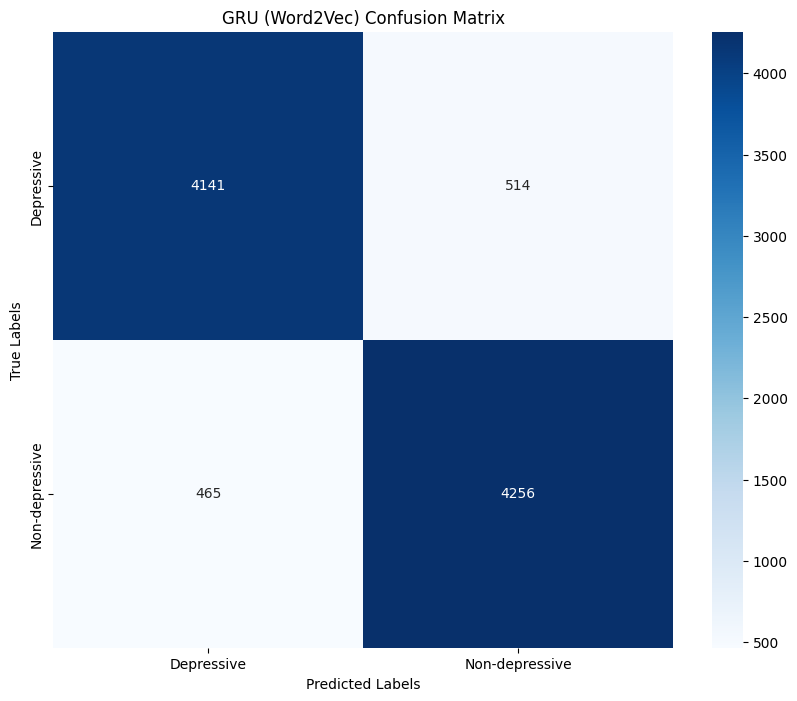

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_word2vec3.jpg


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 32
epochs = 25
dropout = 0.3
learning_rate = 0.01
hidden_size = 128
num_layers = 4  # GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_word2vec3.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/30, Loss: 0.4864
Epoch 2/30, Loss: 0.2191
Epoch 3/30, Loss: 0.1383
Epoch 4/30, Loss: 0.0998
Epoch 5/30, Loss: 0.0760
Epoch 6/30, Loss: 0.0596
Epoch 7/30, Loss: 0.0560
Epoch 8/30, Loss: 0.0513
Epoch 9/30, Loss: 0.0638
Epoch 10/30, Loss: 0.0585
Epoch 11/30, Loss: 0.0585
Epoch 12/30, Loss: 0.0475
Epoch 13/30, Loss: 0.0481
Epoch 14/30, Loss: 0.0448
Epoch 15/30, Loss: 0.0418
Epoch 16/30, Loss: 0.0404
Epoch 17/30, Loss: 0.0399
Epoch 18/30, Loss: 0.0411
Epoch 19/30, Loss: 0.0418
Epoch 20/30, Loss: 0.0411
Epoch 21/30, Loss: 0.0445
Epoch 22/30, Loss: 0.0440
Epoch 23/30, Loss: 0.0449
Epoch 24/30, Loss: 0.0472
Epoch 25/30, Loss: 0.0464
Epoch 26/30, Loss: 0.0448
Epoch 27/30, Loss: 0.0435
Epoch 28/30, Loss: 0.0401
Epoch 29/30, Loss: 0.0413
Epoch 30/30, Loss: 0.0411
Accuracy: 0.9806
                precision    recall  f1-score   support

    Depressive       0.99      0.97      0.98      4655
Non-depressive       0.97      0.99      0.98      4

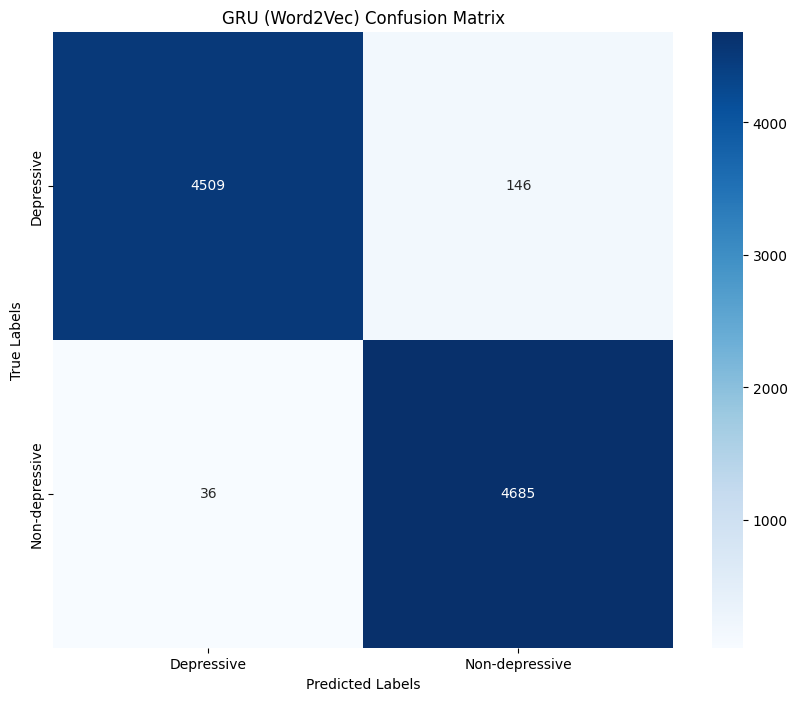

Confusion matrix saved at: /kaggle/working/confusion_matrix_gru_word2vec4.jpg


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 64
epochs = 30
dropout = 0.3
learning_rate = 0.001
hidden_size = 128
num_layers = 4  # GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = GRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_gru_word2vec4.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


# GRU (FastText)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")
    

from gensim.models.keyedvectors import KeyedVectors

# Load FastText embeddings
def load_fasttext_embeddings(file_path):
    print("Loading FastText embeddings...")
    model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    embeddings = {word: model[word] for word in model.index_to_key}
    return embeddings

# Specify the path to your FastText binary embeddings
fasttext_path = "/kaggle/input/first-text/GoogleNews-vectors-negative300.bin"  # Replace with actual path
fasttext_embeddings = load_fasttext_embeddings(fasttext_path)
print("FastText embeddings loaded.")


# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = fasttext_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)

# GRU Model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Configurations
configurations = [
    {"batch_size": 16, "epochs": 10, "dropout": 0.3, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 3},
    {"batch_size": 16, "epochs": 20, "dropout": 0.3, "learning_rate": 0.01, "hidden_size": 128, "num_layers": 2},
    {"batch_size": 32, "epochs": 25, "dropout": 0.4, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 3},
    {"batch_size": 32, "epochs": 30, "dropout": 0.3, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 4},
    {"batch_size": 64, "epochs": 35, "dropout": 0.3, "learning_rate": 0.01, "hidden_size": 128, "num_layers": 3}
]

# Loop through configurations
for idx, config in enumerate(configurations, start=1):
    print(f"\nTraining GRU Model for Configuration {idx}: {config}")
    batch_size, epochs, dropout, learning_rate, hidden_size, num_layers = config.values()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = GRUClassifier(embedding_matrix, hidden_size, num_layers, len(df['label'].unique()), dropout).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, labels = [item.to(DEVICE) for item in batch]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            inputs, labels = [item.to(DEVICE) for item in batch]
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nConfiguration {idx}: Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = ['Depressive', 'Non-depressive']

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"GRU (FastText) Confusion Matrix - Config {idx}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Save Confusion Matrix
    confusion_matrix_path = f"/kaggle/working/confusion_matrix_gru_fasttext_{idx}.jpg"
    plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Confusion matrix for Configuration {idx} saved at: {confusion_matrix_path}")


Using device: cuda
Loading FastText embeddings...
FastText embeddings loaded.

Training GRU Model for Configuration 1: {'batch_size': 16, 'epochs': 10, 'dropout': 0.3, 'learning_rate': 0.001, 'hidden_size': 128, 'num_layers': 3}
Epoch 1/10, Loss: 0.4613
Epoch 2/10, Loss: 0.2154
Epoch 3/10, Loss: 0.1247
Epoch 4/10, Loss: 0.0832
Epoch 5/10, Loss: 0.0664
Epoch 6/10, Loss: 0.0585
Epoch 7/10, Loss: 0.0553
Epoch 8/10, Loss: 0.0530
Epoch 9/10, Loss: 0.0496
Epoch 10/10, Loss: 0.0527

Configuration 1: Accuracy: 0.9741

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.9633    0.9854    0.9742      4655
Non-depressive     0.9853    0.9629    0.9740      4721

      accuracy                         0.9741      9376
     macro avg     0.9743    0.9742    0.9741      9376
  weighted avg     0.9743    0.9741    0.9741      9376

Confusion matrix for Configuration 1 saved at: /kaggle/working/confusion_matrix_gru_fasttext_1.jpg

Training GRU Model fo

# Bi-GRU (Glove)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
batch_size = 16
epochs = 10
dropout = 0.4
learning_rate = 0.001
hidden_size = 128
num_layers = 2  # Bi-GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Using device: cuda
GloVe embeddings loaded.
Epoch 1/10, Loss: 0.4521
Epoch 2/10, Loss: 0.1978
Epoch 3/10, Loss: 0.1137
Epoch 4/10, Loss: 0.0844
Epoch 5/10, Loss: 0.0640
Epoch 6/10, Loss: 0.0555
Epoch 7/10, Loss: 0.0574
Epoch 8/10, Loss: 0.0487
Epoch 9/10, Loss: 0.0519
Epoch 10/10, Loss: 0.0537
Accuracy: 0.9766
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4655
           1       0.96      1.00      0.98      4721

    accuracy                           0.98      9376
   macro avg       0.98      0.98      0.98      9376
weighted avg       0.98      0.98      0.98      9376



Accuracy: 0.9766
                precision    recall  f1-score   support

    Depressive       1.00      0.96      0.98      4655
Non-depressive       0.96      1.00      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



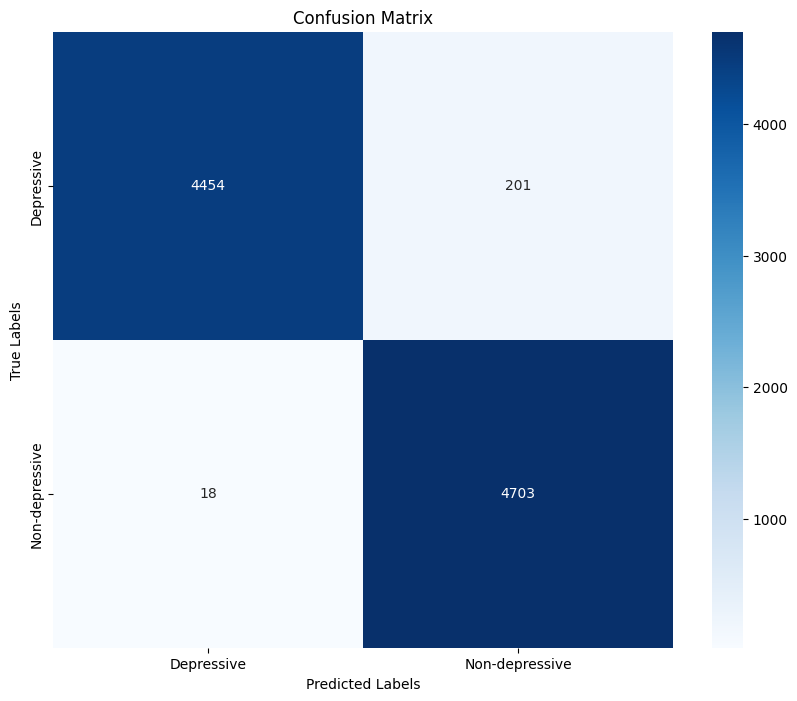

Confusion matrix saved at: /kaggle/working/confusion_matrix3.jpg


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix3.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
batch_size = 32
epochs = 20
dropout = 0.4
learning_rate = 0.001
hidden_size = 128
num_layers = 4  # Bi-GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Using device: cuda
GloVe embeddings loaded.
Epoch 1/20, Loss: 0.4669
Epoch 2/20, Loss: 0.2032
Epoch 3/20, Loss: 0.1316
Epoch 4/20, Loss: 0.0942
Epoch 5/20, Loss: 0.0696
Epoch 6/20, Loss: 0.0547
Epoch 7/20, Loss: 0.0607
Epoch 8/20, Loss: 0.0569
Epoch 9/20, Loss: 0.0542
Epoch 10/20, Loss: 0.0564
Epoch 11/20, Loss: 0.0533
Epoch 12/20, Loss: 0.0493
Epoch 13/20, Loss: 0.0564
Epoch 14/20, Loss: 0.0519
Epoch 15/20, Loss: 0.0477
Epoch 16/20, Loss: 0.0451
Epoch 17/20, Loss: 0.0495
Epoch 18/20, Loss: 0.0546
Epoch 19/20, Loss: 0.0504
Epoch 20/20, Loss: 0.0454
Accuracy: 0.9782
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4655
           1       0.96      1.00      0.98      4721

    accuracy                           0.98      9376
   macro avg       0.98      0.98      0.98      9376
weighted avg       0.98      0.98      0.98      9376



Accuracy: 0.9782
                precision    recall  f1-score   support

    Depressive       1.00      0.96      0.98      4655
Non-depressive       0.96      1.00      0.98      4721

      accuracy                           0.98      9376
     macro avg       0.98      0.98      0.98      9376
  weighted avg       0.98      0.98      0.98      9376



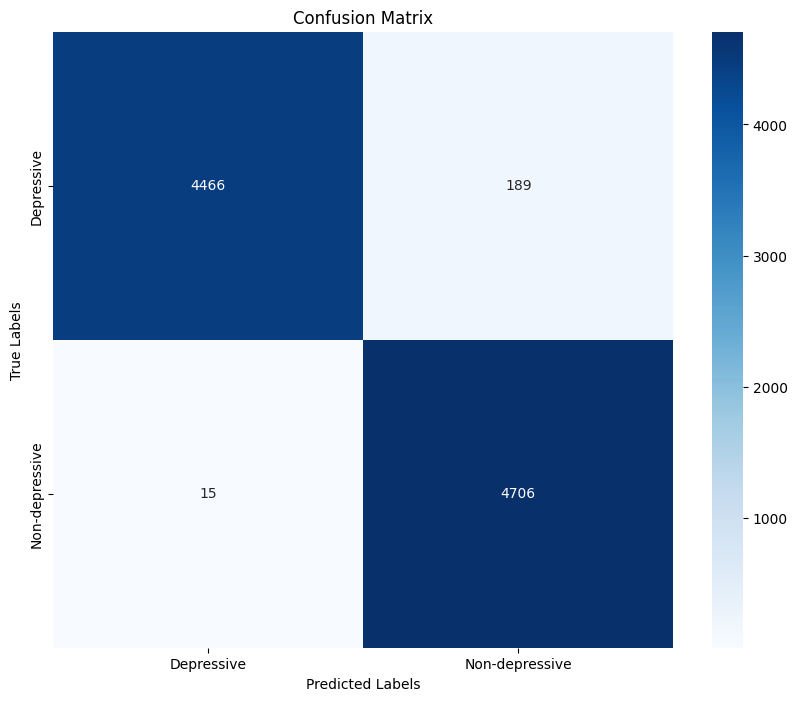

Confusion matrix saved at: /kaggle/working/confusion_matrix2.jpg


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix2.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
batch_size = 64
epochs = 20
dropout = 0.4
learning_rate = 0.0001
hidden_size = 128
num_layers = 3  # Bi-GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Using device: cuda
GloVe embeddings loaded.
Epoch 1/20, Loss: 0.6827
Epoch 2/20, Loss: 0.4111
Epoch 3/20, Loss: 0.2109
Epoch 4/20, Loss: 0.1359
Epoch 5/20, Loss: 0.1071
Epoch 6/20, Loss: 0.0891
Epoch 7/20, Loss: 0.0809
Epoch 8/20, Loss: 0.0737
Epoch 9/20, Loss: 0.0710
Epoch 10/20, Loss: 0.0647
Epoch 11/20, Loss: 0.0586
Epoch 12/20, Loss: 0.0573
Epoch 13/20, Loss: 0.0562
Epoch 14/20, Loss: 0.0528
Epoch 15/20, Loss: 0.0505
Epoch 16/20, Loss: 0.0473
Epoch 17/20, Loss: 0.0488
Epoch 18/20, Loss: 0.0470
Epoch 19/20, Loss: 0.0458
Epoch 20/20, Loss: 0.0437
Accuracy: 0.9798
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4655
           1       0.97      0.99      0.98      4721

    accuracy                           0.98      9376
   macro avg       0.98      0.98      0.98      9376
weighted avg       0.98      0.98      0.98      9376



Accuracy: 0.9724
                precision    recall  f1-score   support

    Depressive       0.95      1.00      0.97      4655
Non-depressive       1.00      0.95      0.97      4721

      accuracy                           0.97      9376
     macro avg       0.97      0.97      0.97      9376
  weighted avg       0.97      0.97      0.97      9376



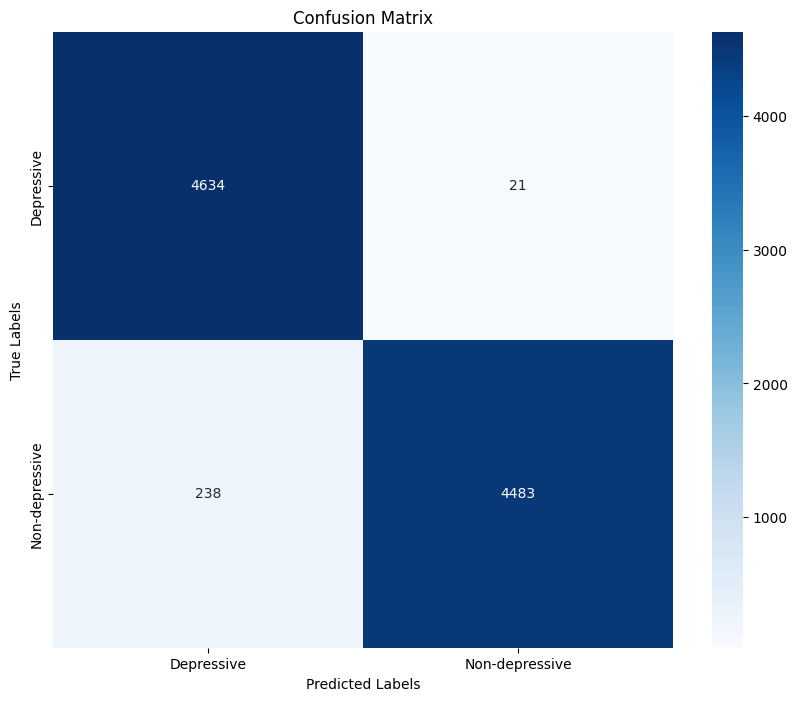

Confusion matrix saved at: /kaggle/working/confusion_matrix1.jpg


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy and Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Human-readable class labels

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix1.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
batch_size = 64
epochs = 25
dropout = 0.4
learning_rate = 0.001
hidden_size = 128
num_layers = 2  # Bi-GRU layers
embedding_dim = 300  # GloVe embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your GloVe embeddings
glove_path = "/kaggle/input/glove-6b-300d/glove.6B.300d.txt"  # Replace with actual path
glove_embeddings = load_glove_embeddings(glove_path)
print("GloVe embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))


Using device: cuda
GloVe embeddings loaded.
Epoch 1/25, Loss: 0.4757
Epoch 2/25, Loss: 0.2030
Epoch 3/25, Loss: 0.1272
Epoch 4/25, Loss: 0.0948
Epoch 5/25, Loss: 0.0783
Epoch 6/25, Loss: 0.0590
Epoch 7/25, Loss: 0.0515
Epoch 8/25, Loss: 0.0478
Epoch 9/25, Loss: 0.0441
Epoch 10/25, Loss: 0.0451
Epoch 11/25, Loss: 0.0454
Epoch 12/25, Loss: 0.0528
Epoch 13/25, Loss: 0.0458
Epoch 14/25, Loss: 0.0432
Epoch 15/25, Loss: 0.0419
Epoch 16/25, Loss: 0.0416
Epoch 17/25, Loss: 0.0454
Epoch 18/25, Loss: 0.0454
Epoch 19/25, Loss: 0.0460
Epoch 20/25, Loss: 0.0415
Epoch 21/25, Loss: 0.0409
Epoch 22/25, Loss: 0.0401
Epoch 23/25, Loss: 0.0398
Epoch 24/25, Loss: 0.0392
Epoch 25/25, Loss: 0.0384
Accuracy: 0.9724
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4655
           1       1.00      0.95      0.97      4721

    accuracy                           0.97      9376
   macro avg       0.97      0.97      0.97      9376
weighted avg       0.97   

Accuracy: 0.9724
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4655
           1       1.00      0.95      0.97      4721

    accuracy                           0.97      9376
   macro avg       0.97      0.97      0.97      9376
weighted avg       0.97      0.97      0.97      9376



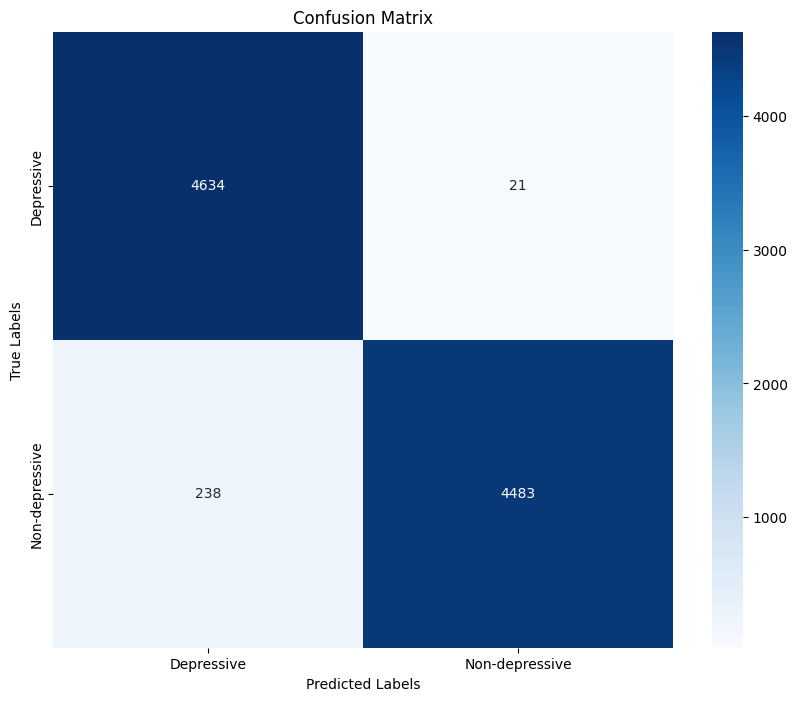

Confusion matrix saved at: /kaggle/working/confusion_matrix.jpg


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


# Bi-GRU (Word2Vec)

Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/15, Loss: 0.4607
Epoch 2/15, Loss: 0.2001
Epoch 3/15, Loss: 0.1135
Epoch 4/15, Loss: 0.0752
Epoch 5/15, Loss: 0.0618
Epoch 6/15, Loss: 0.0568
Epoch 7/15, Loss: 0.0532
Epoch 8/15, Loss: 0.0510
Epoch 9/15, Loss: 0.0487
Epoch 10/15, Loss: 0.0462
Epoch 11/15, Loss: 0.0513
Epoch 12/15, Loss: 0.0468
Epoch 13/15, Loss: 0.0459
Epoch 14/15, Loss: 0.0431
Epoch 15/15, Loss: 0.0512
Accuracy: 0.9798

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.9886    0.9706    0.9795      4655
Non-depressive     0.9715    0.9890    0.9802      4721

      accuracy                         0.9798      9376
     macro avg     0.9801    0.9798    0.9798      9376
  weighted avg     0.9800    0.9798    0.9798      9376



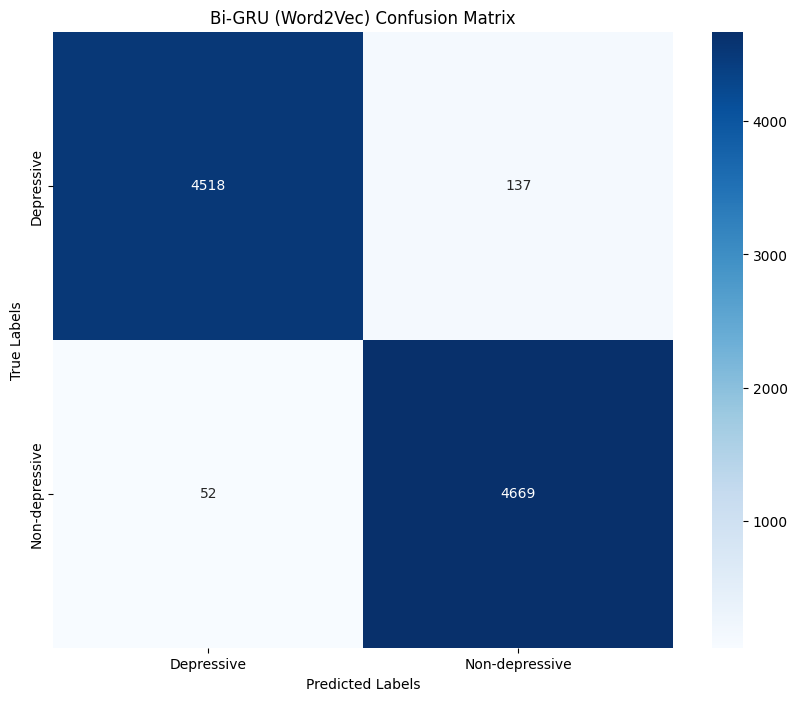

Confusion matrix saved at: /kaggle/working/confusion_matrix_bigru_word2vec1.jpg


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 16
epochs = 15
dropout = 0.2
learning_rate = 0.001
hidden_size = 128
num_layers = 3  # Bi-GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Bi-GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_bigru_word2vec1.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/20, Loss: 0.4680
Epoch 2/20, Loss: 0.2014
Epoch 3/20, Loss: 0.1206
Epoch 4/20, Loss: 0.0819
Epoch 5/20, Loss: 0.0569
Epoch 6/20, Loss: 0.0512
Epoch 7/20, Loss: 0.0526
Epoch 8/20, Loss: 0.0497
Epoch 9/20, Loss: 0.0439
Epoch 10/20, Loss: 0.0467
Epoch 11/20, Loss: 0.0439
Epoch 12/20, Loss: 0.0492
Epoch 13/20, Loss: 0.0461
Epoch 14/20, Loss: 0.0448
Epoch 15/20, Loss: 0.0408
Epoch 16/20, Loss: 0.0397
Epoch 17/20, Loss: 0.0396
Epoch 18/20, Loss: 0.0386
Epoch 19/20, Loss: 0.0390
Epoch 20/20, Loss: 0.0389
Accuracy: 0.9794

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.9769    0.9817    0.9793      4655
Non-depressive     0.9819    0.9771    0.9795      4721

      accuracy                         0.9794      9376
     macro avg     0.9794    0.9794    0.9794      9376
  weighted avg     0.9794    0.9794    0.9794      9376



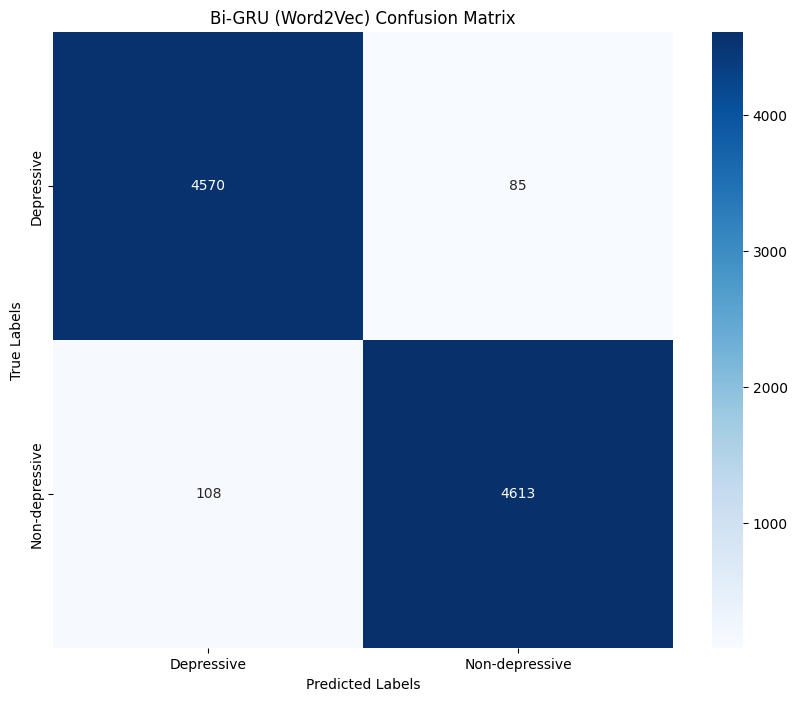

Confusion matrix saved at: /kaggle/working/confusion_matrix_bigru_word2vec2.jpg


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 32
epochs = 20
dropout = 0.4
learning_rate = 0.001
hidden_size = 128
num_layers = 2 # Bi-GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Bi-GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_bigru_word2vec2.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/25, Loss: 0.5849
Epoch 2/25, Loss: 0.3431
Epoch 3/25, Loss: 0.2617
Epoch 4/25, Loss: 0.2406
Epoch 5/25, Loss: 0.2450
Epoch 6/25, Loss: 0.2795
Epoch 7/25, Loss: 0.2884
Epoch 8/25, Loss: 0.3314
Epoch 9/25, Loss: 0.3778
Epoch 10/25, Loss: 0.3554
Epoch 11/25, Loss: 0.3689
Epoch 12/25, Loss: 0.3640
Epoch 13/25, Loss: 0.3705
Epoch 14/25, Loss: 0.3699
Epoch 15/25, Loss: 0.3744
Epoch 16/25, Loss: 0.3972
Epoch 17/25, Loss: 0.3946
Epoch 18/25, Loss: 0.4369
Epoch 19/25, Loss: 0.4387
Epoch 20/25, Loss: 0.4340
Epoch 21/25, Loss: 0.4465
Epoch 22/25, Loss: 0.4269
Epoch 23/25, Loss: 0.4274
Epoch 24/25, Loss: 0.4154
Epoch 25/25, Loss: 0.4338
Accuracy: 0.8052

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.7435    0.9278    0.8255      4655
Non-depressive     0.9058    0.6844    0.7797      4721

      accuracy                         0.8052      9376
     macro avg     0.8247    0.8061    0.802

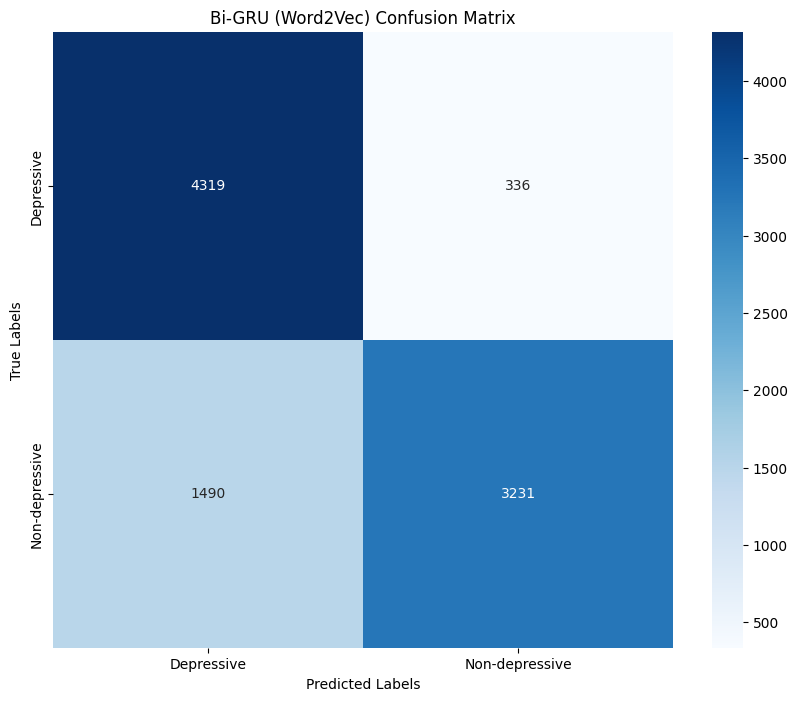

Confusion matrix saved at: /kaggle/working/confusion_matrix_bigru_word2vec3.jpg


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 32
epochs = 25
dropout = 0.3
learning_rate = 0.01
hidden_size = 128
num_layers = 4 # Bi-GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Bi-GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_bigru_word2vec2.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


Using device: cuda
Word2Vec embeddings loaded.
Epoch 1/30, Loss: 0.4972
Epoch 2/30, Loss: 0.2177
Epoch 3/30, Loss: 0.1252
Epoch 4/30, Loss: 0.0925
Epoch 5/30, Loss: 0.0668
Epoch 6/30, Loss: 0.0544
Epoch 7/30, Loss: 0.0526
Epoch 8/30, Loss: 0.0545
Epoch 9/30, Loss: 0.0498
Epoch 10/30, Loss: 0.0437
Epoch 11/30, Loss: 0.0416
Epoch 12/30, Loss: 0.0461
Epoch 13/30, Loss: 0.0447
Epoch 14/30, Loss: 0.0491
Epoch 15/30, Loss: 0.0495
Epoch 16/30, Loss: 0.0444
Epoch 17/30, Loss: 0.0413
Epoch 18/30, Loss: 0.0382
Epoch 19/30, Loss: 0.0387
Epoch 20/30, Loss: 0.0398
Epoch 21/30, Loss: 0.0413
Epoch 22/30, Loss: 0.0412
Epoch 23/30, Loss: 0.0563
Epoch 24/30, Loss: 0.0479
Epoch 25/30, Loss: 0.0436
Epoch 26/30, Loss: 0.0407
Epoch 27/30, Loss: 0.0380
Epoch 28/30, Loss: 0.0390
Epoch 29/30, Loss: 0.0387
Epoch 30/30, Loss: 0.0384
Accuracy: 0.9802

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.9850    0.9749    0.9799      4655
Non-depressive     0.9755  

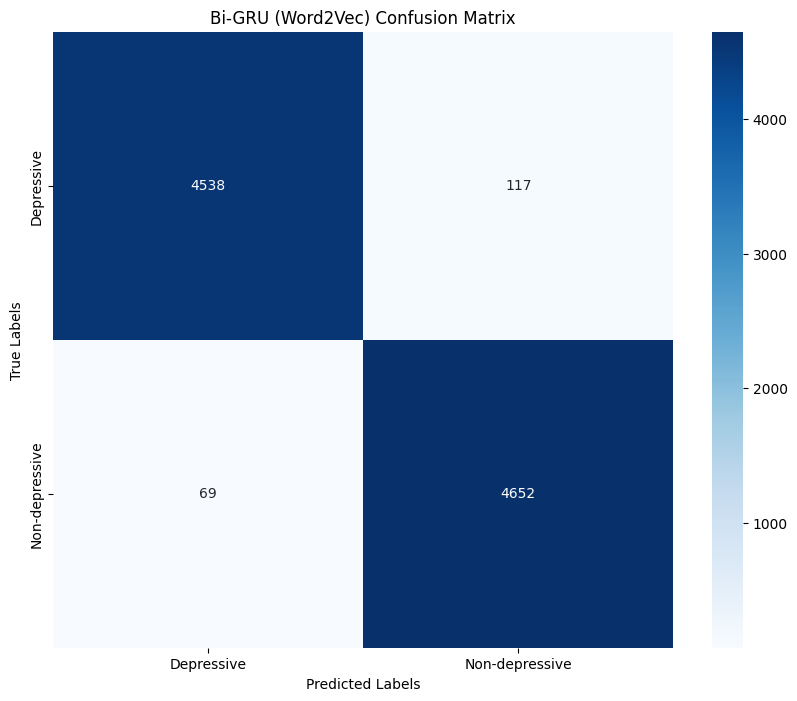

Confusion matrix saved at: /kaggle/working/confusion_matrix_bigru_word2vec4.jpg


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hyperparameters
batch_size = 64
epochs = 30
dropout = 0.3
learning_rate = 0.001
hidden_size = 128
num_layers = 4 # Bi-GRU layers
embedding_dim = 300  # Word2Vec embedding dimension

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load Word2Vec embeddings
def load_word2vec_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Specify the path to your Word2Vec embeddings
word2vec_path = "/kaggle/input/word-2-vector/cc.en.300.vec"  # Replace with actual path
word2vec_embeddings = load_word2vec_embeddings(word2vec_path)
print("Word2Vec embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = word2vec_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Instantiate model, loss, and optimizer
num_classes = len(df['label'].unique())
model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, num_classes, dropout).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = [item.to(DEVICE) for item in batch]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = ['Depressive', 'Non-depressive']  # Replace numeric labels with these

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Bi-GRU (Word2Vec) Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the confusion matrix as a .jpg file
confusion_matrix_path = "/kaggle/working/confusion_matrix_bigru_word2vec4.jpg"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved at: {confusion_matrix_path}")


# Bi-GRU FastText

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load dataset
dataset_path = "/kaggle/input/new-proccessed-data/Processed Data.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'label' columns.")

# Load FastText embeddings
def load_fasttext_embeddings(file_path):
    print("Loading FastText embeddings...")
    model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    embeddings = {word: model[word] for word in model.index_to_key}
    return embeddings

# Specify the path to your FastText binary embeddings
fasttext_path = "/kaggle/input/first-text/GoogleNews-vectors-negative300.bin"  # Replace with actual path
fasttext_embeddings = load_fasttext_embeddings(fasttext_path)
print("FastText embeddings loaded.")

# Tokenize and prepare data
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100  # Adjust based on your dataset

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index

# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = fasttext_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y = df['label'].values
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
X_tensor = torch.tensor(X, dtype=torch.long)
dataset = TensorDataset(X_tensor, y)

# Define Bi-GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, dropout):
        super(BiGRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, 
                          dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-GRU doubles the hidden size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))  # Use the last hidden state
        return out

# Configurations
configurations = [
    {"batch_size": 16, "epochs": 10, "dropout": 0.3, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 3},
    {"batch_size": 16, "epochs": 20, "dropout": 0.3, "learning_rate": 0.01, "hidden_size": 128, "num_layers": 2},
    {"batch_size": 32, "epochs": 25, "dropout": 0.4, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 3},
    {"batch_size": 32, "epochs": 30, "dropout": 0.3, "learning_rate": 0.001, "hidden_size": 128, "num_layers": 4},
    {"batch_size": 64, "epochs": 35, "dropout": 0.3, "learning_rate": 0.01, "hidden_size": 128, "num_layers": 3}
]

# Loop through configurations
for idx, config in enumerate(configurations, start=1):
    print(f"\nTraining Bi-GRU Model for Configuration {idx}: {config}")
    batch_size, epochs, dropout, learning_rate, hidden_size, num_layers = config.values()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = BiGRUClassifier(embedding_matrix, hidden_size, num_layers, len(df['label'].unique()), dropout).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, labels = [item.to(DEVICE) for item in batch]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in train_loader:
            inputs, labels = [item.to(DEVICE) for item in batch]
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nConfiguration {idx}: Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=['Depressive', 'Non-depressive'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = ['Depressive', 'Non-depressive']

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Bi-GRU (FastText) Confusion Matrix - Config {idx}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Save Confusion Matrix
    confusion_matrix_path = f"/kaggle/working/confusion_matrix_bigru_fasttext_{idx}.jpg"
    plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Confusion matrix for Configuration {idx} saved at: {confusion_matrix_path}")


Using device: cuda
Loading FastText embeddings...
FastText embeddings loaded.

Training Bi-GRU Model for Configuration 1: {'batch_size': 16, 'epochs': 10, 'dropout': 0.3, 'learning_rate': 0.001, 'hidden_size': 128, 'num_layers': 3}
Epoch 1/10, Loss: 0.4583
Epoch 2/10, Loss: 0.1971
Epoch 3/10, Loss: 0.1160
Epoch 4/10, Loss: 0.0742
Epoch 5/10, Loss: 0.0601
Epoch 6/10, Loss: 0.0596
Epoch 7/10, Loss: 0.0554
Epoch 8/10, Loss: 0.0519
Epoch 9/10, Loss: 0.0506
Epoch 10/10, Loss: 0.0502

Configuration 1: Accuracy: 0.9746

Classification Report:

                precision    recall  f1-score   support

    Depressive     0.9998    0.9491    0.9738      4655
Non-depressive     0.9522    0.9998    0.9754      4721

      accuracy                         0.9746      9376
     macro avg     0.9760    0.9744    0.9746      9376
  weighted avg     0.9758    0.9746    0.9746      9376

Confusion matrix for Configuration 1 saved at: /kaggle/working/confusion_matrix_bigru_fasttext_1.jpg

Training Bi-GRU 